In [1]:
import get_route_plan
import sys
import pandas as pd
import calendar
import datetime

def get_routes(input_string):
	# Expected input format 'starting_brewery=20 crawl_starts_at=19:00 minutes_per_bar=20 crawl_duration=3 dow_name=Monday'
	inp_list = input_string.split(' ')
	## Get Day of week
	dow_name = inp_list[4].split("=")[1]
	fn_args = {e.split('=')[0]:e.split('=')[1] for e in inp_list[:4]}


	# load data from static reference files
	brewery_data_fpath = 'data/BreweryData.csv'  # path for main brewery file
	fname_trav_times = 'data/timesMatrix.csv'

	### Load Data
	# Opening and Closing Times of Breweries
	def import_data(filepath, day):
	    """Import opening and closing times for all breweries"""

	    # Note that all times are reported in seconds
	    daymap = {'Monday': 'hour_m',
	              'Tuesday': 'hour_tu',
	              'Wednesday': 'hour_wed',
	              'Thursday': 'hour_th',
	              'Friday': 'hour_fr',
	              'Saturday': 'hour_sat',
	              'Sunday': 'hour_sun'}

	    #book = pd.ExcelFile(filepath)
	    data = pd.read_csv(filepath)
	    #data = book.parse(skiprows=1, header=1).dropna(subset=['brewery'])

	    time = data[daymap[day]].apply(lambda x: str(x).split('-')) \
	        .map(
	        lambda x: ['-1:00', '-1:00'] if x[0] == '' or x[0] == 'nan' else x)

	    data['opentime'] = time.map(lambda x: x[0]) \
	        .map(lambda x: x.split(':')) \
	        .map(lambda x: int(x[0]) * 3600 + int(x[1]) * 60) \
	        .map(lambda x: 0 if x < 0 else x)

	    data['closetime'] = time.map(lambda x: x[1]) \
	        .map(lambda x: x.split(':')) \
	        .map(lambda x: int(x[0]) * 3600 + int(x[1]) * 60) \
	        .map(lambda x: 100000 if x < 0 else x)
	    # 100000 (s) arbitrary close time if close time is unknown
	    return data.loc[:, ['brewery', 'opentime', 'closetime', 'dog_friendly', 'serves_food', 'reservations', 'outdoor']]


	# Travel Times Matrix & Other Inputs
	def get_data(fname_trav_times, brewery_timings):
	    # Matrix of travel times (seconds) from every bar to every other bar
	    bars = list(brewery_timings.brewery.values)
	    trav_times = pd.read_csv(fname_trav_times)
	    trav_times = trav_times[trav_times['origin_name'].isin(bars)]
	    trav_times = trav_times[bars]
	    trav_times = trav_times.as_matrix()

	    # how long do you have to wait for the bar to open
	    start_times = brewery_timings.opentime.values
	    # bar closing times
	    end_times = brewery_timings.closetime.values

	    # demand is an arbitrary, unit-less number that must be low enough that
	    # it never exceeds 'capacity'
	    # when the vehicle visits a location, it 'meets the demand' at that
	    # location - the solver tries to maximize the
	    # demand met, while staying within the vehicle's 'capacity'
	    demands = [1] * len(start_times)

	    data = [demands, start_times, end_times, trav_times, bars]
	    return data



	brewery_timings = import_data(brewery_data_fpath, day=dow_name)
	start_brew = brewery_timings.iloc[int(fn_args['starting_brewery'])-1, 0]

	if len(inp_list) > 5:
	    for e in inp_list[5:]:
	        fil = e.split('=')
	        brewery_timings = brewery_timings[brewery_timings[fil[0]] == 1.0]
	    brewery_timings = brewery_timings.loc[:, ['brewery', 'opentime', 'closetime']]

	brewery_timings.reset_index(inplace=True)
	fn_args['starting_brewery'] = list(brewery_timings[brewery_timings['brewery'] == start_brew].index)[0]
	data = get_data(fname_trav_times, brewery_timings)
	res = get_route_plan.generate_route_plan(data, brewery_timings, **fn_args)
	return res



In [9]:
def create_counter(time):
    # generate input strings cycling thru every bar set as the starting point
    input_string_list = []

    for bar_num in range(1, 35):

        # For a 5 hr crawl on a Friday, starting at 7 PM
        input_string = 'starting_brewery={} crawl_starts_at={} minutes_per_bar=45 crawl_duration=4 dow_name=Friday'.format(bar_num, time)
        input_string_list += [input_string]

    res = []
    for item in input_string_list:
        # ignore the first bar, which is always the starting bar
        res += get_routes(item)[1:]

    from collections import Counter
    from pprint import pprint

    res_bar_name_only = [item[0] for item in res]
    return Counter(res_bar_name_only)

In [10]:
Brewery = ['21st Amendment Brewery', 'Barebottle Brewing', 'Barrel Head Brewhouse',
        'Bartlett Hall', 'Beach Chalet Restaurant & Brewery', 'Black Hammer Brewing', 
        'Black Sands Brewery', 'Cellarmaker Brewing Co.', 'Emporium', 'Ferment.Drink.Repeat',
        'Harmonic Brewing', 'Laughing Monk Brewing Co.', 'Local Brewing Co.',
        'Magnolia Brewing Co.', 'Mikkeller Bar', 'Old Bus Tavern', 'Public House',
         'Rogue Ales Public House', 'SMOKESTACK at Magnolia Brewing Co.',
         'Seven Stills - Brewery & Distillery', 'Smugglers Cove', 
        'Social Kitchen & Brewery', 'Southpaw BBQ & Brewery', 
        'Speakeasy Ales and Lagers', 'Standard Deviant Brewing',
        'Sunset Reservoir Brewing Co.', 'ThirstyBear Organic Brewery',
        'Triple Voodoo Brewery','Woods Cerveceria', 'Woods Outbound',
        'Woods Polk Station']

In [11]:
c = create_counter('19:00')

In [12]:
c

Counter({'21st Amendment Brewery': 6,
         'Barebottle Brewing': 2,
         'Barrel Head Brewhouse': 5,
         'Bartlett Hall': 2,
         'Beach Chalet Restaurant & Brewery': 2,
         'Black Hammer Brewing': 8,
         'Black Sands Brewery': 4,
         'Cellarmaker Brewing Co.': 6,
         'Emporium': 6,
         'Ferment.Drink.Repeat': 7,
         'Harmonic Brewing': 5,
         'Laughing Monk Brewing Co.': 5,
         'Local Brewing Co.': 2,
         'Magnolia Brewing Co.': 5,
         'Mikkeller Bar': 1,
         'Public House': 2,
         'Rogue Ales Public House': 2,
         'SMOKESTACK at Magnolia Brewing Co.': 5,
         'Seven Stills - Brewery & Distillery': 5,
         'Smugglers Cove': 2,
         'Social Kitchen & Brewery': 3,
         'Southpaw BBQ & Brewery': 2,
         'Standard Deviant Brewing': 2,
         'Sunset Reservoir Brewing Co.': 2,
         'ThirstyBear Organic Brewery': 5,
         'Triple Voodoo Brewery': 5,
         'Woods Cerveceria': 1,


In [13]:
len(c)

29

In [14]:
arr = [c[b] for b in Brewery]
arr

[6,
 2,
 5,
 2,
 2,
 8,
 4,
 6,
 6,
 7,
 5,
 5,
 2,
 5,
 1,
 0,
 2,
 2,
 5,
 5,
 2,
 3,
 2,
 0,
 2,
 2,
 5,
 5,
 1,
 2,
 2]

In [15]:
len(arr)

31

In [16]:
c

Counter({'21st Amendment Brewery': 6,
         'Barebottle Brewing': 2,
         'Barrel Head Brewhouse': 5,
         'Bartlett Hall': 2,
         'Beach Chalet Restaurant & Brewery': 2,
         'Black Hammer Brewing': 8,
         'Black Sands Brewery': 4,
         'Cellarmaker Brewing Co.': 6,
         'Emporium': 6,
         'Ferment.Drink.Repeat': 7,
         'Harmonic Brewing': 5,
         'Laughing Monk Brewing Co.': 5,
         'Local Brewing Co.': 2,
         'Magnolia Brewing Co.': 5,
         'Mikkeller Bar': 1,
         'Public House': 2,
         'Rogue Ales Public House': 2,
         'SMOKESTACK at Magnolia Brewing Co.': 5,
         'Seven Stills - Brewery & Distillery': 5,
         'Smugglers Cove': 2,
         'Social Kitchen & Brewery': 3,
         'Southpaw BBQ & Brewery': 2,
         'Standard Deviant Brewing': 2,
         'Sunset Reservoir Brewing Co.': 2,
         'ThirstyBear Organic Brewery': 5,
         'Triple Voodoo Brewery': 5,
         'Woods Cerveceria': 1,


In [17]:
len(arr)

31

In [18]:
len(Brewery)

31

In [19]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

In [21]:
ind = np.argsort(arr)

In [22]:
ind

array([15, 23, 28, 14, 25, 24, 22, 20, 17, 16, 29, 12, 30,  1,  3,  4, 21,
        6, 27, 26,  2, 13, 19, 18, 10, 11,  7,  8,  0,  9,  5])

In [23]:
arr_s = np.array(arr)[ind]
arr_s

array([0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 7, 8])

In [24]:
brewery_s = np.array(Brewery)[ind]
brewery_s

array(['Old Bus Tavern', 'Speakeasy Ales and Lagers', 'Woods Cerveceria',
       'Mikkeller Bar', 'Sunset Reservoir Brewing Co.',
       'Standard Deviant Brewing', 'Southpaw BBQ & Brewery',
       'Smugglers Cove', 'Rogue Ales Public House', 'Public House',
       'Woods Outbound', 'Local Brewing Co.', 'Woods Polk Station',
       'Barebottle Brewing', 'Bartlett Hall',
       'Beach Chalet Restaurant & Brewery', 'Social Kitchen & Brewery',
       'Black Sands Brewery', 'Triple Voodoo Brewery',
       'ThirstyBear Organic Brewery', 'Barrel Head Brewhouse',
       'Magnolia Brewing Co.', 'Seven Stills - Brewery & Distillery',
       'SMOKESTACK at Magnolia Brewing Co.', 'Harmonic Brewing',
       'Laughing Monk Brewing Co.', 'Cellarmaker Brewing Co.', 'Emporium',
       '21st Amendment Brewery', 'Ferment.Drink.Repeat',
       'Black Hammer Brewing'],
      dtype='|S35')

In [26]:
arr_s[-13:]

array([5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 8])

In [54]:
zipy = zip(np.arange(13), arr_s[-13:]+1)

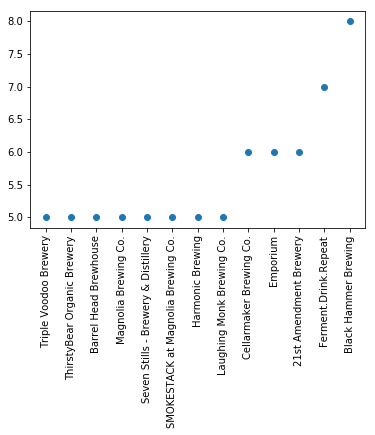

In [27]:
plt.scatter(np.arange(13),arr_s[-13:])
plt.xticks(np.arange(13), brewery_s[-13:], rotation = 90)
plt.savefig('bre', bbox_inches = 'tight', dpi = 100)
plt.show()

In [28]:
np.median(arr_s)

2.0

In [19]:
Time = ['17:00','17:30', '18:00', '18:30', '19:00', '19:30', '20:00',
       '20:30', '21:00', '21:30', '22:00', '22:30']

In [20]:
arr = []
for t in Time:
    c = create_counter(t)
    arr.append([f[b] for b in Brewery])

In [22]:
import numpy as np

In [23]:
np.array(arr).shape

(12, 31)

In [26]:
np.array(arr).T

array([[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [2,

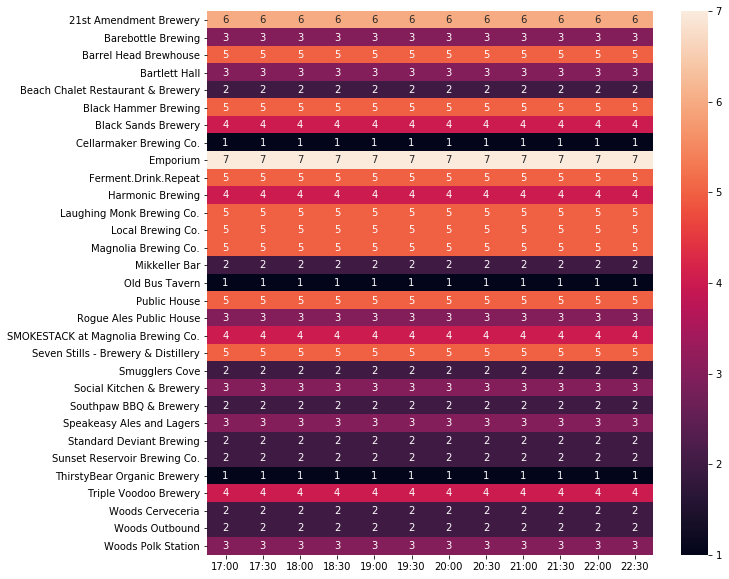

In [30]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

Index= Brewery
Cols = Time
input = np.array(arr).T
df = DataFrame(input, index=Index, columns=Cols)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df, annot=True)